BRITANNIA.NS    2733.266602
RELIANCE.NS      664.744385
TCS.NS          1894.864014
Name: 2020-02-20 00:00:00+05:30, dtype: float64

=== HISTORICAL EVENT STRESS TEST RESULTS (Tickers) ===

Scenario: COVID Crash
Period: 2020-02-01 to 2020-03-23
Tickers Used: ['BRITANNIA.NS', 'RELIANCE.NS', 'TCS.NS']
Initial Portfolio Value: ₹50000.00
Final Portfolio Value: ₹36997.92
PnL Impact: ₹-13002.08
Pct Change: -26.00%

Scenario: 2014 Elections
Period: 2014-04-01 to 2014-12-31
Tickers Used: ['BRITANNIA.NS', 'RELIANCE.NS', 'TCS.NS']
Initial Portfolio Value: ₹50000.00
Final Portfolio Value: ₹67973.14
PnL Impact: ₹17973.14
Pct Change: 35.95%

Scenario: Lehman Crisis
Period: 2008-09-15 to 2009-03-09
Tickers Used: ['BRITANNIA.NS', 'RELIANCE.NS', 'TCS.NS']
Initial Portfolio Value: ₹50000.00
Final Portfolio Value: ₹33931.98
PnL Impact: ₹-16068.02
Pct Change: -32.14%

Scenario: Trump Tariff Shock India 2025
Period: 2025-06-30 to 2025-07-30
Tickers Used: ['BRITANNIA.NS', 'RELIANCE.NS', 'TCS.NS']
Initial Po

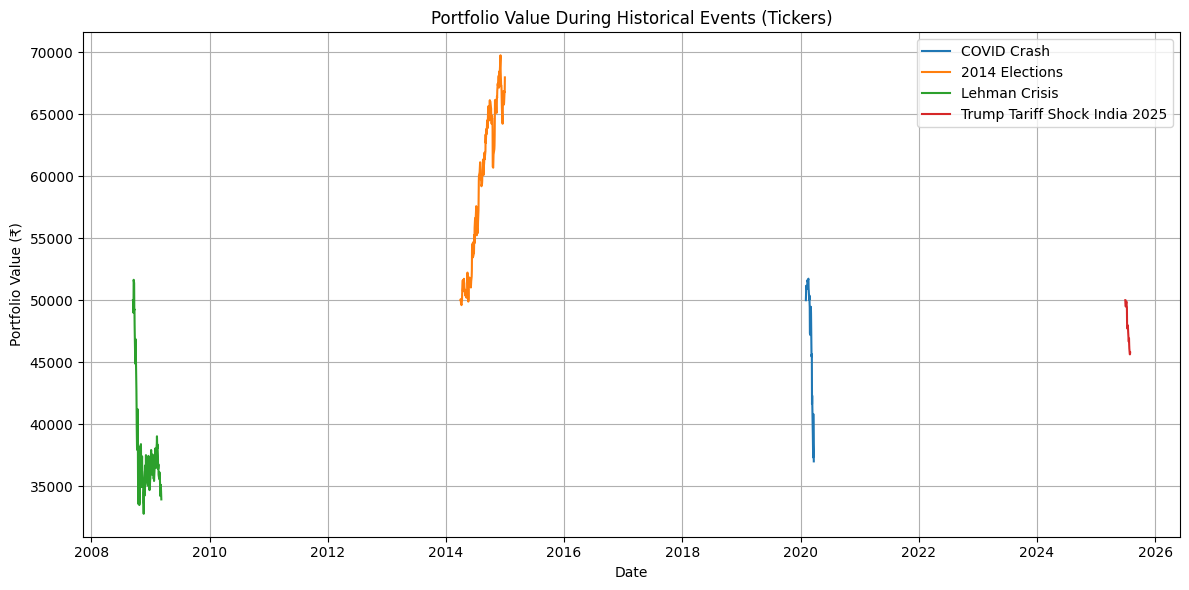

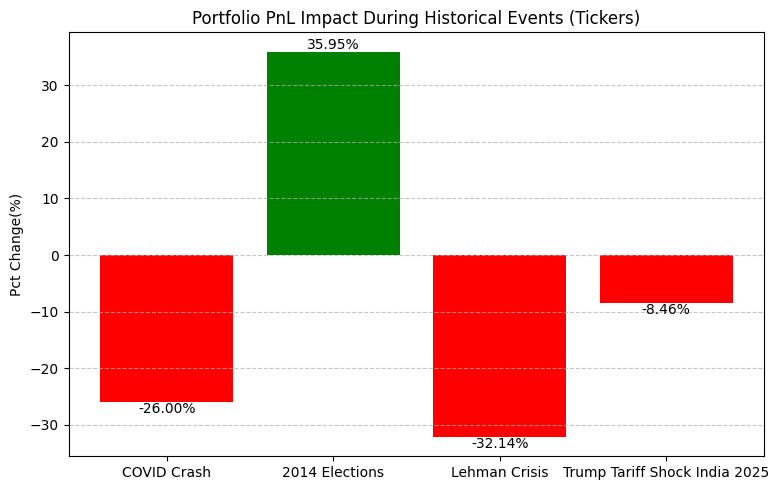

In [87]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 1. USER INPUT
# -----------------------------
tickers = ["BRITANNIA.NS", "RELIANCE.NS", "TCS.NS"]  # Your stock tickers
weights_input = np.array([0.2, 0.2, 0.6])         # Must sum to 1
aum = 50000                                        # Total portfolio value

# Historical events to stress-test
historical_scenarios = {
    "COVID Crash": {"start": "2020-02-01", "end": "2020-03-23"},
    "2014 Elections": {"start": "2014-04-01", "end": "2014-12-31"},
    "Lehman Crisis": {"start": "2008-09-15", "end": "2009-03-09"},
    "Trump Tariff Shock India 2025": {"start": "2025-06-30", "end": "2025-07-30"}

}

# -----------------------------
# 2. DOWNLOAD PRICE DATA INDIVIDUALLY
# -----------------------------
price_data_dict = {}
for t in tickers:
    df = yf.Ticker(t).history(start="2008-01-01", end=pd.Timestamp.today().strftime('%Y-%m-%d'))
    price_data_dict[t] = df['Close']  # Use only actual Close prices

# Combine into a single DataFrame
prices = pd.DataFrame(price_data_dict)
prices = prices.sort_index()  # Ensure chronological order
prices = prices.bfill()  # Fill any missing prices

# -----------------------------
# 3. RUN HISTORICAL SCENARIOS
# -----------------------------
historical_results = {}
portfolio_series_dict = {}
print(prices.loc["2020-02-20"])
for name, dates in historical_scenarios.items():
    # Filter prices for the scenario period
    scenario_prices = prices.loc[dates["start"]:dates["end"]]

    # Keep only tickers with data in this period
    scenario_prices = scenario_prices.dropna(axis=1, how="all")
    if scenario_prices.empty:
        print(f"Warning: No price data available for {name}. Skipping scenario.")
        continue

    scenario_tickers = scenario_prices.columns.tolist()

    # Adjust weights proportionally
    scenario_weights = weights_input[[tickers.index(t) for t in scenario_tickers]]
    scenario_weights = scenario_weights / scenario_weights.sum()

    # Compute shares based on first price
    shares = scenario_weights * aum / scenario_prices.iloc[0]

    # Portfolio value time series
    portfolio_ts = (scenario_prices * shares).sum(axis=1)

    # PnL
    pnl = portfolio_ts.iloc[-1] - portfolio_ts.iloc[0]

    # Store results
    historical_results[name] = {
        "Start Date": dates["start"],
        "End Date": dates["end"],
        "Tickers Used": scenario_tickers,
        "Initial Portfolio Value": portfolio_ts.iloc[0],
        "Final Portfolio Value": portfolio_ts.iloc[-1],
        "PnL Impact": pnl,
        "Percent Change": (pnl / portfolio_ts.iloc[0]) * 100
    }

    portfolio_series_dict[name] = portfolio_ts

# -----------------------------
# 4. PRINT RESULTS
# -----------------------------
print("\n=== HISTORICAL EVENT STRESS TEST RESULTS (Tickers) ===")
for name, r in historical_results.items():
    print(f"\nScenario: {name}")
    print(f"Period: {r['Start Date']} to {r['End Date']}")
    print(f"Tickers Used: {r['Tickers Used']}")
    print(f"Initial Portfolio Value: ₹{r['Initial Portfolio Value']:.2f}")
    print(f"Final Portfolio Value: ₹{r['Final Portfolio Value']:.2f}")
    print(f"PnL Impact: ₹{r['PnL Impact']:.2f}")
    print(f"Pct Change: {r['Percent Change']:.2f}%")

# -----------------------------
# 5. PLOT PORTFOLIO VALUE OVER TIME
# -----------------------------
plt.figure(figsize=(12, 6))
for name, series in portfolio_series_dict.items():
    plt.plot(series.index, series.values, label=name)

plt.title("Portfolio Value During Historical Events (Tickers)")
plt.xlabel("Date")
plt.ylabel("Portfolio Value (₹)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------------
# 6. PLOT PnL BAR CHART
# -----------------------------
plt.figure(figsize=(8, 5))
scenario_names = list(historical_results.keys())
pnl_values = [historical_results[name]["Percent Change"] for name in scenario_names]

bars = plt.bar(scenario_names, pnl_values, color=['red' if x < 0 else 'green' for x in pnl_values])
plt.title("Portfolio PnL Impact During Historical Events (Tickers)")
plt.ylabel("Pct Change(%)")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f"{height:,.2f}%",
             ha='center', va='bottom' if height >=0 else 'top', fontsize=10)

plt.tight_layout()
plt.show()
